写一些东西，方便理解如何求SVM的hinge_LOSS和权重矩阵$W$的梯度$dW$。

假设我们共有10张图片，被分为3类。
用$X_i$(`imgs[i](i=1,2,...,10)`)表示第$i$张图片的所有像素，$y_i$(`label[i]`)表示第$i$张图片对应的类别标签（`label[i]=0,1,2`）。
假设每张图片的长和宽都为2个像素，有3个通道（$\color{red}{R}\color{green}{G}\color{blue}{B}$）。

In [1]:
import numpy as np

imgs = np.random.rand(10, 2, 2, 3)
label = np.random.randint(0, 3, size=10)
img_test = np.random.rand(2, 2, 2, 3)

print("前2张图片是：\n", imgs[:2])
print("\n所有图片的标签是：\n", label)

前2张图片是：
 [[[[0.44610755 0.50850947 0.06605838]
   [0.46162918 0.19888073 0.57064383]]

  [[0.98715871 0.42333655 0.69537932]
   [0.23180493 0.3750864  0.04938028]]]


 [[[0.07719142 0.32079032 0.66292269]
   [0.00509739 0.41437673 0.91452219]]

  [[0.60394883 0.72229577 0.3316002 ]
   [0.59225726 0.54067025 0.19174882]]]]

所有图片的标签是：
 [2 1 0 2 1 2 2 2 1 1]


为了方便后续处理，将每张图片reshape为长度为$2\times2\times3 = 12$的向量，
并且添加一个1在矢量末尾作为偏置维度（bias dimension），因此图片空间的维度$D=12+1=13$。

In [2]:
imgs = imgs.reshape(10, -1)
imgs = np.hstack([imgs, np.ones((imgs.shape[0], 1))])

print("处理后的前2张图片是：\n", imgs[:2])
print("\n共有%d张图片，每张图片的维度是%d。\n"%imgs.shape)

处理后的前2张图片是：
 [[0.44610755 0.50850947 0.06605838 0.46162918 0.19888073 0.57064383
  0.98715871 0.42333655 0.69537932 0.23180493 0.3750864  0.04938028
  1.        ]
 [0.07719142 0.32079032 0.66292269 0.00509739 0.41437673 0.91452219
  0.60394883 0.72229577 0.3316002  0.59225726 0.54067025 0.19174882
  1.        ]]

共有10张图片，每张图片的维度是13。



为了对图片做分类，SVM的想法是用一个$13\times 3$维的线性变换$W$将图片向量$X_i$从图片空间（13维）映射到类别空间（3维），
若将线性变换后的向量记作$S_i$，则$S_i$在某一维度$j$上的分量$S_{ij}$即为第$i$张图片在第$j$类上的得分。
一个朴素的想法是，得分$S_{ij}$越高，就代表着第$i$张图片越应该被分在第$j$类。

我们已知第i张图片的分类$y_i$，因此可以将$S_{iy_i}$和$S_{ij}(j\neq y_i)$作差进行比较，
并且设定一个所谓的“安全距离”$\Delta$——当$S_{iy_i} - S_{ij}(j\neq y_i) \ge \Delta$时，
我们就可以认为相比于第$j$类，第$i$张图片已经被足够好地分在了第$y_i$类，
即“分类足够正确”。因此可以写出第$i$张图片的损失函数：

$$L_i = \sum_{j\neq y_i}\max(0,\ S_{ij} - S_{iy_i} + \Delta) = \sum_{j\neq y_i}\max(0,\ (W^T)_j \cdot X_i - (W^T)_{y_i} \cdot X_i + \Delta)$$

根据上述定义和运算，$W$的第$j$列对应着分到第$j$类的权重，$S_{ij} = (W^T)_j \cdot X_i$，即$W_{nj}$本质上代表着任何一张图片的第$n$个像素点对于将这张图片分为第$j$类的贡献（权重）。

In [3]:
# 随机初始化一个权重矩阵W
W = np.random.randn(13, 3)
S = np.dot(imgs, W)

print("W是一个%d*%d维矩阵\n"%W.shape, W)
print("\nS是一个%d*%d维矩阵\n"%S.shape, S)

W是一个13*3维矩阵
 [[ 0.38922976 -1.5476645   0.29391136]
 [ 1.88278845 -2.03980096  0.87708064]
 [ 0.6370439   1.20157172 -1.41819386]
 [-0.72895385  1.54486262 -0.13406272]
 [-1.0054797  -0.87397261  0.97254715]
 [ 1.4744262  -0.09882989  0.06366316]
 [ 1.07822844  1.34769706  1.57454748]
 [ 0.11163696 -1.39929385 -0.46959958]
 [ 1.61945353 -0.25428393 -1.06335361]
 [ 0.19482573  0.42195421  0.34891287]
 [ 1.51212699 -2.70581067 -0.03097324]
 [ 0.78342346  0.2109576   0.17596721]
 [-0.38857257  0.52356264 -0.07280062]]

S是一个10*3维矩阵
 [[ 3.9782615  -0.98729542  1.27254517]
 [ 3.94780649 -1.3520439   0.23442124]
 [ 4.75273802 -0.32327394 -1.08898947]
 [ 5.24844741 -1.91383568  1.44559066]
 [ 4.39185774 -0.42945789  1.34646468]
 [ 4.64370727 -2.85630203  0.36418856]
 [ 3.67487502 -2.61126693 -0.97194457]
 [ 2.64962175 -1.43415149  0.23078515]
 [ 2.69766682 -1.9465858  -0.15695445]
 [ 1.8519816   0.27556944  0.24302435]]


为了求出第$i$张图片的损失函数$L_i$，首先从得分矩阵$S$中挑出所有真实分类的得分，将其延展为与$S$相同的维度，
与得分矩阵$S$作差后加上$\Delta$即可得到（未经处理的）$L$矩阵：

In [10]:
correct_scores = S[range(S.shape[0]), label].reshape(-1,1)
print("correct_scores:\n", correct_scores)
correct_scores = np.hstack([correct_scores] * S.shape[1])
print("\n", correct_scores)
Delta = 1  # 一个相对任意选择的“安全距离”
L = S - correct_scores + Delta
print("\nL:\n", L)
print("\nlabels:", label)

correct_scores:
 [[ 1.27254517]
 [-1.3520439 ]
 [ 4.75273802]
 [ 1.44559066]
 [-0.42945789]
 [ 0.36418856]
 [-0.97194457]
 [ 0.23078515]
 [-1.9465858 ]
 [ 0.27556944]]

 [[ 1.27254517  1.27254517  1.27254517]
 [-1.3520439  -1.3520439  -1.3520439 ]
 [ 4.75273802  4.75273802  4.75273802]
 [ 1.44559066  1.44559066  1.44559066]
 [-0.42945789 -0.42945789 -0.42945789]
 [ 0.36418856  0.36418856  0.36418856]
 [-0.97194457 -0.97194457 -0.97194457]
 [ 0.23078515  0.23078515  0.23078515]
 [-1.9465858  -1.9465858  -1.9465858 ]
 [ 0.27556944  0.27556944  0.27556944]]

L:
 [[ 3.70571632 -1.25984059  1.        ]
 [ 6.2998504   1.          2.58646514]
 [ 1.         -4.07601195 -4.84172749]
 [ 4.80285675 -2.35942634  1.        ]
 [ 5.82131563  1.          2.77592256]
 [ 5.27951872 -2.22049058  1.        ]
 [ 5.64681958 -0.63932236  1.        ]
 [ 3.41883661 -0.66493664  1.        ]
 [ 5.64425262  1.          2.78963135]
 [ 2.57641216  1.          0.96745491]]

labels: [2 1 0 2 1 2 2 2 1 1]


可以看到$L$矩阵中出现了很多$1$，这些$1$出现的位置正是每张图片的正确分类位置，
即$L_{iy_i} = \Delta (= 1)$。根据$L_i$的定义，我们还需要做两步操作：

1. 将每个图片的正确分类位置置零，因为公式中并不包含这一项；
2. 将小于零的位置置零，因为公式中的$\max(0, blabla)$保证了这一点。

我们使用一个蒙版`mask`来实现这两步处理，而不直接修改$L$本身。

（注：使用`mask`的好处将在计算梯度$dW$时得以体现。）

In [11]:
mask = np.ones(L.shape)
mask[range(L.shape[0]), label] = 0  # 正确分类位置置零
mask[L < 0] = 0  # 小于零的位置置零
L *= mask

print("mask = \n", mask)
print("\nL = \n", L)

mask = 
 [[1. 0. 0.]
 [1. 0. 1.]
 [0. 0. 0.]
 [1. 0. 0.]
 [1. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 1.]
 [1. 0. 1.]]

L = 
 [[ 3.70571632 -0.          0.        ]
 [ 6.2998504   0.          2.58646514]
 [ 0.         -0.         -0.        ]
 [ 4.80285675 -0.          0.        ]
 [ 5.82131563  0.          2.77592256]
 [ 5.27951872 -0.          0.        ]
 [ 5.64681958 -0.          0.        ]
 [ 3.41883661 -0.          0.        ]
 [ 5.64425262  0.          2.78963135]
 [ 2.57641216  0.          0.96745491]]


经过处理的$L$中仍不为0的位置实际上就是分类结果不够好的位置，数字越大就代表分类结果越差；
反之，若第i行的数字全为0，则代表当前的$W$不仅对于第i张图片的分类是正确的，
并且将其他图片拒于“安全距离”以外。

现在，$L$的第i行数字之和即为$L_i$，矩阵中所有数字之和即为总的损失函数$L$：

In [12]:
L = np.sum(L, axis=1)
print("L = ", L)
loss = np.sum(L) / len(L)
print("\nloss = ", loss)

[3.70571632 8.88631554 0.         4.80285675 8.59723819 5.27951872
 5.64681958 3.41883661 8.43388397 3.54386707]


5.231505276181342

试想，如果将$W$扩大$\alpha$倍，那么除了损失函数也相应地扩大$\alpha$倍以外，不会再有其他影响。
由此，我们可以为损失函数添加正则惩罚(regularization penalty)，这其中蕴含着奥卡姆剃刀的思想，
即鼓励简化、鼓励稀疏、反对不必要的复杂，这同时也能一定程度上防止过拟合。
公式中的$\lambda$是正则惩罚的力度，$\sum_k\sum_l W_{k,l}^2$是当前的$W$与零矩阵的Frobenius范数，
用来定量评估两者的差异。

加入正则惩罚的总损失函数为：

$$L = \frac{1}{N} \sum_i \sum_{j\neq y_i} \left[ \max(0,\ (X_i\cdot W)_j - (X_i\cdot W)_{y_i} + \Delta) \right] + \lambda \sum_k\sum_l W_{k,l}^2\\$$

将上面的步骤进行整合就可以写出完整的`svm_loss`函数：

In [14]:
def svm_loss(W, X, y, delta, reg):
    """
    SVM loss function, vectorized implementation.

    Input images have dimension D, there are C classes, and we operate on N examples.

    Inputs:
    - W: A numpy array of shape (D, C) containing weights.
    - X: A numpy array of shape (N, D) containing a minibatch of data.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c means
      that X[i] has label c, where 0 <= c < C.
    - delta: (float) classification safe margin
    - reg: (float) regularization strength

    Return:
    - loss as single float
    """

    S = np.dot(X, W)
    correct_scores = S[range(S.shape[0]), y].reshape(-1,1)
    correct_scores = np.hstack([correct_scores] * S.shape[1])

    L = S - correct_scores + delta

    mask = np.ones(L.shape)
    mask[range(L.shape[0]), y] = 0  # 正确分类位置置零
    mask[L < 0] = 0  # 小于零的位置置零
    L *= mask

    loss = np.sum(L) / len(L)
    loss += reg * np.sum(W * W)

    return loss

In [23]:
loss = svm_loss(W, imgs, label, delta=1, reg=0.005)
print("loss = ", loss)

loss =  5.458238730215393


现在来计算梯度矩阵$dW$。根据梯度的定义，$dW$具有如下原始形式：

\begin{equation}
    \nabla_{W} L
    :=
    \begin{bmatrix}
        \frac{dL}{dW_{11}} & \frac{dL}{dW_{12}} & \cdots & \frac{dL}{dW_{1C}} \\
        \frac{dL}{dW_{21}} & \frac{dL}{dW_{22}} & \cdots & \frac{dL}{dW_{2C}} \\
        \vdots & \vdots & \ddots & \vdots \\
        \frac{dL}{dW_{D1}} & \frac{dL}{dW_{D2}} & \cdots & \frac{dL}{dW_{DC}}
    \end{bmatrix}
\end{equation}

在本例中，图片数量为$N=10$，图片空间维度$D=13$，类别数$C=3$。由于上面的数据是随机生成的，
故每次运行程序所得的`mask`也不同。现在以下面给定的`mask`为例做一些分析，为后续的向量化计算$dW$捋清思路。
为了简明，只分析`mask`的前两行。

\begin{equation}
    mask
    =
    \begin{bmatrix}
        \color{red}{0} & 1 & 1 \\
        1 & \color{green}{0} & \color{red}{0} \\
        \vdots & \vdots & \vdots \\
    \end{bmatrix}
\end{equation}

这里红色的$\color{red}{0}$代表因为分类正确而置零，绿色的$\color{green}{0}$代表因为小于零而置零（参考上面的分析）。
现在以这个`mask`为例分析梯度$dW$中的几个元素。先写出$L_1$最终的表达式：

$$L_1 = (S_{12} - S_{11} + \Delta) + (S_{13} - S_{11} + \Delta)$$

利用链式法则可以得到

$$\frac{\partial L_1}{\partial W_{11}} = \sum_j \frac{\partial L_1}{\partial S_{1j}} \frac{\partial S_{1j}}{\partial W_{11}} = (-2) X_{11}$$

同理，
$$\frac{\partial L_1}{\partial W_{n1}} = \sum_j \frac{\partial L_1}{\partial S_{1j}} \frac{\partial S_{1j}}{\partial W_{n1}} = (-2) X_{1n}$$

这里的系数$-2$来自于`mask`中第一行有2个1，其中的负号是因为$W$的第二个下标1正好对应第一张图片的正确分类标签$y_1 = 0$
（注：此处的图片被分为三类，即$\{1,2,3\}$，对应分类的标签$\{0,1,2\}$），从而$S_{11}$出现在公式里的负号后。
因此$L_1$对$dW$的第1列贡献了$-2$个$X_1$

再看另一个元素：

$$\frac{\partial L_1}{\partial W_{12}} = \sum_j \frac{\partial L_1}{\partial S_{1j}} \frac{\partial S_{1j}}{\partial W_{12}} = X_{11}$$

同理，$$\frac{\partial L_1}{\partial W_{n2}} = \sum_j \frac{\partial L_1}{\partial S_{1j}} \frac{\partial S_{1j}}{\partial W_{n2}} = X_{1n} \ ,\ \frac{\partial L_1}{\partial W_{n3}} = \sum_j \frac{\partial L_1}{\partial S_{1j}} \frac{\partial S_{1j}}{\partial W_{n3}} = X_{1n}$$

与上面的分析类同，$L_1$对$dW$的第2列和第3列分别贡献了1个$X_1$。将目前已经分析过的部分写成更简练的矩阵形式：

\begin{equation}
    \nabla_{W} L_1
    =
    \begin{bmatrix}
        X_1 & X_2 & \cdots & X_N
    \end{bmatrix}
    \begin{bmatrix}
        \color{red}{-2} & 1 & 1 \\
        0 & 0 & 0 \\
        \vdots & \vdots & \vdots \\
    \end{bmatrix}
    =
    X^T mask_1
\end{equation}

接下来分析$L_2$，与$L_1$完全类同，但由于$L_2 = (S_{21} - S_{23} + \Delta)$，
$L_2$对$dW$的第1列贡献了1个$X_1$，第3列贡献了-1个$X_1$，写进矩阵即为：

\begin{equation}
    \nabla_{W} L_2
    =
    \begin{bmatrix}
        X_1 & X_2 & \cdots & X_N
    \end{bmatrix}
    =
    X^T \begin{bmatrix}
        0 & 0 & 0 \\
        1 & \color{green}{0} & \color{red}{-1} \\
        0 & 0 & 0 \\
        \vdots & \vdots & \vdots \\
    \end{bmatrix}
\end{equation}

将$mask_1,mask_2$与$mask$对比可知，$mask_i$就是将$mask$的第$i$行单独取出，
在红色位置（即第$i$张图片的正确分类位置）上填入$mask$的第$i$行之和的相反数。
最终完整的$dW$矢量化计算公式为：

\begin{equation}
    \nabla_{W} L
    =
    \sum_{i=1}^N \nabla_{W} L_i
    =
    \begin{bmatrix}
        X_1 & X_2 & \cdots & X_N
    \end{bmatrix}
    \sum_{i=1}^N mask_i
    =
    X^T
    \begin{bmatrix}
        \color{red}{-2} & 1 & 1 \\
        1 & \color{green}{0} & \color{red}{-1} \\
        \vdots & \vdots & \vdots \\
    \end{bmatrix}
\end{equation}

还要加入正则化惩罚：

\begin{equation}
    \nabla_{W} L
    =
    \frac{1}{N} X^T
    \begin{bmatrix}
        \color{red}{-2} & 1 & 1 \\
        1 & \color{green}{0} & \color{red}{-1} \\
        \vdots & \vdots & \vdots \\
    \end{bmatrix} + 2\lambda W
\end{equation}

由此可以写出完整的代码：

In [24]:
def svm_loss_grad(W, X, y, delta, reg):
    """
    Structured SVM loss function, vectorized implementation.

    Inputs have dimension D, there are C classes, and we operate on minibatches
    of N examples.

    Inputs:
    - W: A numpy array of shape (D, C) containing weights.
    - X: A numpy array of shape (N, D) containing a minibatch of data.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c means
      that X[i] has label c, where 0 <= c < C.
    - delta: (float) classification safe margin
    - reg: (float) regularization strength

    Returns a tuple of:
    - loss as single float
    - gradient with respect to weights W; an array of same shape as W
    """

    loss = 0.0
    dW = np.zeros(W.shape)  # initialize the gradient as zero

    # A vectorized version of the structured SVM loss and gradient.
    S = np.dot(X, W)
    correct_scores = S[range(S.shape[0]), y].reshape(-1,1)

    # 利用numpy的broadcast特性可以省略下面这行代码
    # correct_scores = np.hstack([correct_scores] * S.shape[1])

    L = S - correct_scores + delta

    mask = np.ones(L.shape)
    mask[range(L.shape[0]), y] = 0  # 正确分类位置置零
    mask[L < 0] = 0  # 小于零的位置置零
    L *= mask

    loss += np.sum(L) / X.shape[0]
    loss += reg * np.sum(W * W)

    dW += np.dot(X.T, mask) / X.shape[0]  # D*C = D*N dot N*C
    dW += 2 * reg * W

    return loss, dW

In [109]:
loss, dW = svm_loss_grad(W, imgs, label, delta=1, reg=0.005)
loss, dW

(7.457803289988815,
 array([[-0.06685351, -0.08443495, -0.04007769],
        [-0.03463011, -0.05389141, -0.02550633],
        [-0.03927926, -0.04445769, -0.06018695],
        [-0.05720121, -0.04758712, -0.06605697],
        [-0.04060118, -0.02268876, -0.03123908],
        [-0.05290632, -0.05539774, -0.06639562],
        [-0.04763426, -0.04088936, -0.0429609 ],
        [-0.05755835, -0.06501836, -0.04997568],
        [-0.05682862, -0.08448008, -0.08736774],
        [-0.06769446, -0.04170579, -0.06186615],
        [-0.05542174, -0.07509581, -0.06060786],
        [-0.04871209, -0.05045147, -0.05053867],
        [-0.12712141, -0.09735306, -0.10617105]]))

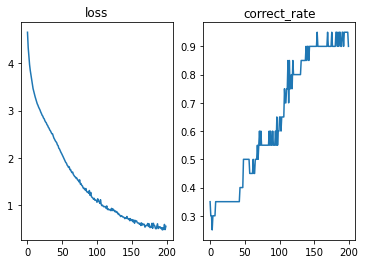

In [170]:
import matplotlib.pyplot as plt

N = 20  # 图片数量
C = 4   # 分类数量
D = 3   # 图片尺寸
# 随机初始化
imgs = np.random.rand(N, D, D, 3)
label = np.random.randint(0, C, size=N)

imgs = imgs.reshape(N, -1)
imgs = np.hstack([imgs, np.ones((imgs.shape[0], 1))])
W = np.random.randn(imgs.shape[1], C)

loss_list, correct_rate_list = [], []
T = np.arange(200)  # 训练次数
alpha = 0.2         # 学习率（步长）
delta = 1           # 安全距离
reg = 5e-5          # 正则惩罚强度

for t in T:
    loss, dW = svm_loss_grad(W, imgs, label, delta=delta, reg=reg)
    W -= alpha * dW

    scores = np.dot(imgs, W)
    label_pred = np.argmax(scores, axis=1)
    correct_rate = np.sum(label_pred == label) / len(label)

    loss_list.append(loss)
    correct_rate_list.append(correct_rate)

fig = plt.figure()
plt.subplot(1,2,1)
plt.plot(T, loss_list)
plt.title("loss")

plt.subplot(1,2,2)
plt.plot(T, correct_rate_list)
plt.title("correct_rate")

plt.show()
